# Adversarial Input Generator

To generate such an input, this notebook uses the fast gradient sign method (FGSM) on the pre-trained ResNet50 neural network provided by keras. An explanation of FGSM can be found [here](https://arxiv.org/pdf/1412.6572.pdf)

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras import backend as K, losses
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf

/Applications/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
sess = tf.Session()
K.set_session(sess)
model = ResNet50(weights='imagenet')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

The image selected has an African bush elephant, which is correctly classified by the neural network.

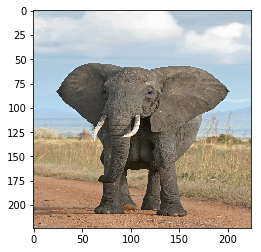

In [4]:
x = image.img_to_array(image.load_img('African_Bush_Elephant.jpg', target_size=(224, 224)))
x = np.expand_dims(x, axis=0)
plt.imshow(x[0, :, :, :].astype(int))

In [12]:
preds = model.predict(preprocess_input(x.copy()))
pred_names = decode_predictions(preds, top=1)[0]
print('Top prediction:', pred_names[0])

Top prediction: ('n02504458', 'African_elephant', 0.8978991)


In [6]:
#preparing for input generation.
with open('resnet50/imagenet_class_index.json') as f:
    global class_names
    class_dict = json.load(f)
    class_names = list(class_dict.values())
    
one_index = class_names.index(['n02504458', 'African_elephant'])

# true = np.zeros()
true = np.zeros(len(class_names)) 
true[one_index] = 1

Using FGSM with cross-entropy loss, the adversarial input is generated.

In [22]:
epsilon = 15
ce_loss = losses.categorical_crossentropy(true, model.output)
nu = K.sign(K.gradients(ce_loss, model.inputs))

nu_value = sess.run(nu,feed_dict={model.input:preprocess_input(x.copy())}) #TODO: clean this up!

new_x = x + epsilon*nu_value

The image still looks very much like the original elephant, though it's a bit more noisy. In addition, ResNet was successfully sabotaged, classifying the elephant as a triceratops.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


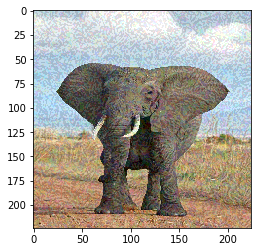

In [23]:
plt.imshow(new_x[0, 0, :, :, :].astype(int))

In [24]:
preds = model.predict(preprocess_input(new_x[0, :, :, :, :].copy()))
pred_names = decode_predictions(preds, top=1)[0]
print('Top prediction:', pred_names[0])

Top prediction: ('n01704323', 'triceratops', 0.5733295)
